## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, several supervised algorithms were employed to accurately model individuals' income using data collected from the 1994 U.S. Census.The best candidate algorithm was then chosen from the initial results. This algorithm was then further optimized to model the data better. The end goal was to construct a model that best predicts whether an individual makes $50,000 or not. This sort of task arises in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, this value can be inferred from publically available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. The data that was investigated in this notebook consists of small chsnges to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
The last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Importing libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("census.csv")

# Displaying the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, the following will be computed:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.



In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data["income"].value_counts()[">50K"]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data["income"].value_counts()["<=50K"]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k)/(n_records)*100

# Printing the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

In the code cell below, a histogram of these two features will be plotted.  The range of values and their distribution will be noted.

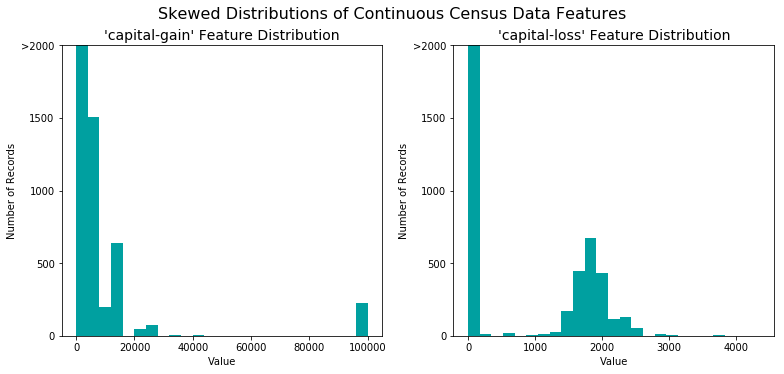

In [3]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

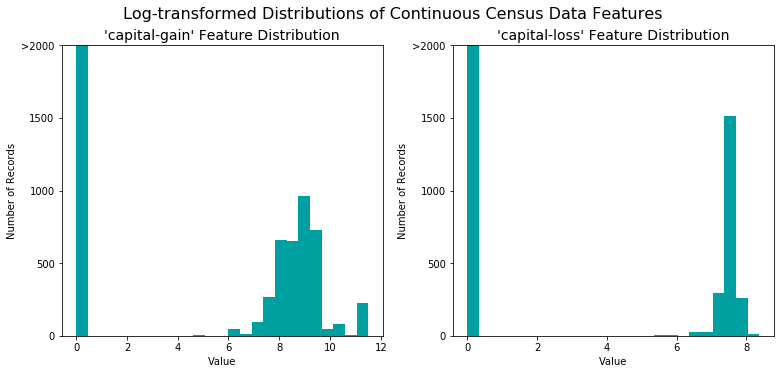

In [4]:
# Log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

In the code cell below, each numerical feature will be normalized. [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) will be used for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then applying it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, the following will be implemente:
 - [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) will be used to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - The target label `'income_raw'` will be converted to numerical entries.
   - The records with "<=50K" will be set to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0, '>50K':1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)



103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

The code cell below performs the split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be chosen supervised learners, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classification), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
# Calculating accuracy, precision and recall
accuracy = 0.2478439697
recall = 1
precision = 0.2478439697

# Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = 0.2917291354

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression


In the following cell (using the questions below), three supervised learning models that will be used for the census data problem will be briefly explained.

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?


#### Support Vector Machines

- SVMs are used in the industry for image classification and face recognition tasks. They are able to decipher and put well defined margins in dividing points on feature maps. They can also be well fine-tuned for extraction and recognition [[1](https://data-flair.training/blogs/applications-of-svm/)].


- SVMs perform well in various scenarios. One such situation is when there is a clear separation or margin between the classes involved [[2](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/)]. They also perform well when the datasets or of small or medium size due to the high training time involved in training large datasets [[2](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/)]. SVMs are less prone to overfitting in high-dimensional spaces [[3](https://iq.opengenus.org/advantages-of-svm/)]. And lastly, it performs well in domains and problems where margins are very important [[3](https://iq.opengenus.org/advantages-of-svm/)].


- SVMs may not exactly be an ideal choice for large training sets due to the training time involved [[2](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/)]. SVM classifiers may also struggle if there is an overlap in the classes [[2](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/)]. And lastly, the non-parametric nature of SVMs can make them difficult to interpret unlike other classifiers [[2](https://roboticsbiz.com/pros-and-cons-of-support-vector-machine-svm/)].


- The reasons for choosing SVMs for this problem consist of the following: They work well in higher dimensional spaces, they give us a clear margin of separation, they are robut against overfitting, especially in a high dimensional space, and they offer different kernel functions for decision boundary. 

#### Random Forest

- Random forest classifiers are used extensively in the banking industry due to their ability to detect fraudulent credit card transactions. They are used due to their ability to handle large imbalanced datasets and also the increased accuracy they offer when cross-validation is performed [[4](https://iq.opengenus.org/applications-of-random-forest/)].


- Random Forest classifiers are adept at handling non-linear relationships between feature variables and target variables as well as complex relationships between variables[[5](https://crunchingthedata.com/when-to-use-random-forests/)], they work effectively with high dimensional data[[5](https://crunchingthedata.com/when-to-use-random-forests/)], they handle outliers very well[[5](https://crunchingthedata.com/when-to-use-random-forests/)], and produce decent results on large datasets [[6](https://neptune.ai/blog/random-forest-regression-when-does-it-fail-and-why)].

- Limitations of the random forest classifier include: It becomes computationally slow when an increased number of trees is desired for more accuracy[[6](https://builtin.com/data-science/random-forest-algorithm)], it isn't directly interpretable like simpler models such as linear regression[[5](https://crunchingthedata.com/when-to-use-random-forests/)], and it isn't the best model involved especially not as good as gradient boosting classifiers [[5](https://crunchingthedata.com/when-to-use-random-forests/)].


- Random Forest classifiers can help us for the following reasons: They handle large number of features well, they perform well with minimal hyperparameter tuning, they can handle both numerical and categorical data, and lastly they are quite robust to overfitting with many features.

#### Gradient Boosting

- The Gradient Boosting model has been effectively applied in forecasting the green innovation performance of corporations. In a study analyzing China's A-share listed companies, this model outperformed linear models, decision trees, and random forests, demonstrating its efficacy in evaluating the impact of internal and external factors on corporate green innovation [[7](https://www.frontiersin.org/articles/10.3389/fenvs.2023.1252271/full)].


- Gradient boosting is particularly effective with complex datasets where relationships between variables are non-linear, the model works well with large datasets, and it's quite robust to overfitting. 

- Limitations include: It's computationally intensive and time-consuming, it requires a lot of tuning, and it performs poorly for very small datasets. 

- The reasons for using Gradient boosting for our problem: It provides very high accuracy, it works well with imbalanced datasets, and it's capable of capturing complex relationships in the data. 

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that a training and prediction pipeline is created that will allow the models to be quickly and effectively trained using various sizes of training data while also allowing predictions to be performed on the testing data. 
In the code block below, the following will be implemented:
 - Importation of `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fitting the learner to the sampled training data and recording the training time.
 - Performing predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Recording the total prediction time.
 - Calculating the accuracy score for both the training subset and testing set.
 - Calculating the F-score for both the training subset and testing set.
   - The `beta` parameter will also be set.

In [9]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score



def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fitting the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = end - start
        
    # Getting the predictions on the test set(X_test),
    #       then getting predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = end - start
            
    # Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Computing F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # Computing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
   
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Returning the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, the following will be implemented:
- Importation of the three supervised learning models you've discussed in the previous section.
- Initialization of the three models and storing them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Usage of a `'random_state'` for each model used.
  -  The default settings for each model will be used here.
- Calculatation of  the number of records equal to 1%, 10%, and 100% of the training data.
  - Storage of the values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


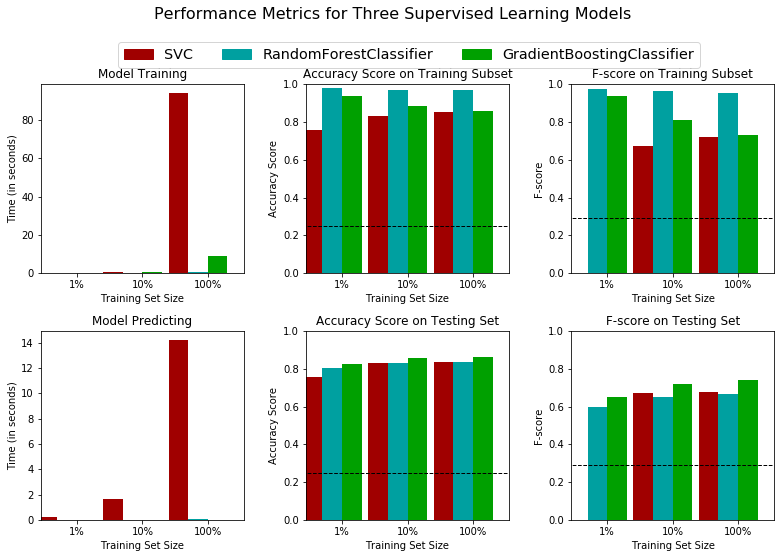

In [14]:
# Importing the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initializing the three models
clf_A = SVC(random_state = 56)
clf_B = RandomForestClassifier(random_state=56)
clf_C = GradientBoostingClassifier(random_state=56)

# Calculating the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(.1 * samples_100)
samples_1 = int(.01 * samples_100)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Running metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, the *best* model from the three supervised learning models will be chosen to be used on the student data. A grid search optimization will then be performed for the model over the entire training set by tuning parameters to improve upon the untuned model's F-score. 

### Report on Initial Model Evaluation

Model evaluation was performed on the three models that were thought to be the most effective in performing this binary classification task. These included: The Support vector classifier, random forest classifier, and the Gradient boosting classifier. All three models were initialised with its default parameters and evaluated on performance based on its evaluation scores and training/prediction times.

From the analysis, it seems the Gradient Boosting Classifier came out on top in both the Fbeta and accuracy measure irrespective of the size of the training set with the gap widening the higher the training set.The Gradient boosting classifier and the random forest classifier were also quite quick in training and predicting especially when you compared it to the SVM classifier. The algorithm seems to work well with the data because of how large, complex and non-linear it is.

### How the model works

Essentially, the gradient boosting algorithm is an ensemble model, in the sense that it combines different "weak" models to create a strong and effective model. Usually these "weaker" models are simple decision trees. Gradient descent isn't the only ensemble model but it works in a unique way. It adds up the trees in a sequence, slowly (depending on the learning rate) reducing the "error" called residuals by the subsequent trees. 

The model first starts off with a leaf that makes the same prediction for every record. The difference between these predictions and the observed values (called residuals) are now calculated. Another tree is then created to fit these residuals using the features. After getting the output value with some math, this value is then combined after being qualified with the learning rate with the initial prediction to get a new prediction, The process continues till the residual becomes very small or we've reached the limit from the hyperparameters. Predictions from unseen data are made by fitting the features through the trees to find the prediction. 

### Implementation: Model Tuning


In [10]:

# Importing necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import fbeta_score, accuracy_score
# Initializing the classifier
clf = GradientBoostingClassifier(random_state=56)

# Creating the parameters list
parameters = {'n_estimators': [100, 200, 300], 'max_depth': [3, 4, 5, 6]}

#  Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fitting the grid search object to the training data and finding the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Getting the estimator
best_clf = grid_fit.best_estimator_



# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8698
Final F-score on the testing data: 0.7501


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |         0.8630    |        0.8698   |
| F-score        |         0.7305    |        0.7501   |


### Report on FInal Model Evaluation

A grid search was performed on our chosen model to tune the hyperparameters effectively; hence optimising the model performance. Once the search was performed and the best parameters were chosen, there was a slight but insignificant increase in the model's accuracy. However the fscore was raised from 73% to 75%.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

A scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute will be chosen, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell, this classifier will be fit to the training set and the attribute will be used to determine the most important features of the census dataset.

Based on trivial knowledge I think the most important features would be: Education, Age, Education-num, occupation, and Marital Status in prder of importance. I'd say level of Education might be the most important because people with higher education are more likely to have decent jobs; Age because you'd have much more time in your career; Education-num because having a higher education usually entails spending much more time in school; Occupation because all jobs have different pay; and lastly marital status because richer people tend to marry because they have enough funds to start a family.

### Implementation - Extracting Feature Importance


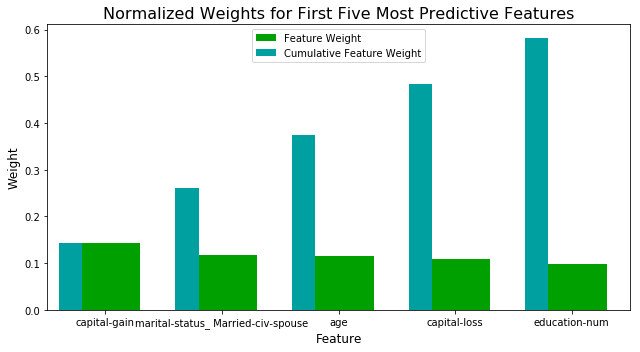

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
# Training the supervised model on the training set using .fit(X_train, y_train)
model  = GradientBoostingClassifier(random_state=56, n_estimators = 100, max_depth=5)
model.fit(X_train, y_train)


# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

3 out of the 5 features I guessed would be the most important were featured on the graph. Those three include education-num, age and Marital Status. The other two that I didn't mention were capital-gain and capital-loss. The three I picked confirmed my inital thoughts, especially marital status where the category that was featured was that of "Married-civ-spouse".

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Importing functionality for cloning a model
from sklearn.base import clone
from sklearn.metrics import fbeta_score, accuracy_score


# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8698
F-score on testing data: 0.7501

Final Model trained on reduced data
------
Accuracy on testing data: 0.8584
F-score on testing data: 0.7243



- Using the reduced dataset, the accuracy of was reduced by 1 percentage point to 85.8% while the F-score was reduced by about 2.5 percentage points to 72.4%

- Given the reduced speed it took the train the model with the reduced dataset, I might consider using the reduced data since the reduction in the Accuracy and F-scores doesn't seem to be too detrimental.

In [14]:

# Converting to an HTML file
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 494497 bytes to finding_donors.html']